# Exercise 6 / Quasi-Newton Methods

### Overview

1. Implement DFP method and compare it with first-order methods

1. Implement BFGS method and compare it with first-order methods

1. Analyze error plots of the respective optimization methods applied for different tasks

### Submission

When done, paste your code into the quiz on Moodle and answer the questions.

## Utilities

In [106]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from typing import Callable
from numpy.typing import NDArray
from sklearn.datasets import make_regression
from sklearn.datasets import make_classification
from scipy.optimize import minimize

In [107]:
def contour_map(
    f: Callable[[NDArray], float],
    xb: tuple[float, float] = (-1.0, 1.0),
    yb: tuple[float, float] = (-1.0, 1.0),
    ax=None,
) -> None:
    """Plots the contour lines of a scalar function on a 2D grid.

    Args:
        f (Callable[[NDArray], float]): Scalar function mapping points to values.
        xb (tuple[float, float], optional): Lower and upper bounds for the x-axis. Defaults to (-1.0, 1.0).
        yb (tuple[float, float], optional): Lower and upper bounds for the y-axis. Defaults to (-1.0, 1.0).
        ax (optional): The axes to plot on. Defaults to None.
    """
    if ax is None:
        ax = plt
    (nx, ny) = (45, 45)
    x = np.linspace(*xb, nx)
    y = np.linspace(*yb, ny)
    xv, yv = np.meshgrid(x, y)
    grid = np.block([[xv.reshape(1, -1)], [yv.reshape(1, -1)]]).T
    values = np.fromiter((f(point) for point in grid), dtype=np.double)
    ax.contour(xv, yv, values.reshape(nx, ny), 15)


def surface_plot(
    f: Callable[[NDArray], float],
    xb: tuple[float, float] = (-1.0, 1.0),
    yb: tuple[float, float] = (-1.0, 1.0),
) -> tuple[plt.Figure, Axes3D]:
    """Creates a 3D surface plot of a scalar function on a 2D grid.

    Args:
        f (Callable[[NDArray], float]): Scalar function mapping points to values.
        xb (tuple[float, float], optional): Lower and upper bounds for the x-axis. Defaults to (-1.0, 1.0).
        yb (tuple[float, float], optional): Lower and upper bounds for the y-axis. Defaults to (-1.0, 1.0).
    Returns:
        tuple[plt.Figure, Axes3D]: Figure and axis containing the rendered surface.
    """
    (nx, ny) = (45, 45)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    x = np.linspace(*xb, nx)
    y = np.linspace(*yb, ny)
    xv, yv = np.meshgrid(x, y)
    grid = np.block([[xv.reshape(1, -1)], [yv.reshape(1, -1)]]).T
    values = np.fromiter((f(point) for point in grid), dtype=np.double)
    ax.plot_surface(xv, yv, values.reshape(nx, ny), cmap=cm.coolwarm)
    return fig, ax

In [108]:
def backtracking_line_search(
    x: NDArray,
    d: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    alpha: float = 0.3,
    beta: float = 0.8,
) -> float:
    """Performs Armijo backtracking line search for a descent direction.

    Args:
        x (NDArray): Current point in parameter space.
        d (NDArray): Candidate descent direction.
        f (Callable[[NDArray], float]): Objective function producing scalar values.
        g (Callable[[NDArray], NDArray]): Gradient of the objective function.
        alpha (float, optional): Armijo sufficient decrease parameter. Defaults to 0.3.
        beta (float, optional): Multiplicative shrink factor for the step size. Defaults to 0.8.
    Returns:
        float: Step length that satisfies the Armijo condition.
    """
    step_size = 1.0
    fx = f(x)
    grad_x = g(x)
    directional_derivative = grad_x.dot(d)

    while f(x + step_size * d) > fx + alpha * step_size * directional_derivative:
        prev_step_size = step_size
        step_size *= beta
        if prev_step_size == step_size: break # If the floating point numbers are equal, we have reached the machine precision limits.

    return step_size


def non_descent_backtracking_line_search(
    x: NDArray,
    d: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    alpha: float = 1.0,
    beta: float = 0.8,
) -> float:
    """Line search for methods that do not guarantee a descent direction.
    Finds a step size that satisfies a modified sufficient decrease condition.

    Args:
        x (NDArray): The current point.
        d (NDArray): The search direction (not necessarily a descent direction).
        f (Callable[[NDArray], float]): The objective function.
        g (Callable[[NDArray], NDArray]): The gradient of the objective function.
        alpha (float, optional): The parameter of the modified sufficient decrease condition. Defaults to 0.3.
        beta (float, optional): The factor by which to reduce the step size per iteration. Defaults to 0.8.

    Returns:
        float: The step size that satisfies the modified sufficient decrease condition.
    """
    step_size = 1.0
    fx: float = f(x)
    grad_x = g(x)
    directional_derivative = grad_x.dot(d)
    while (
        f(x + step_size * d)
        > fx + alpha * step_size * directional_derivative + step_size / 2 * d.T @ d
    ):
        prev_step_size = step_size
        step_size *= beta
        if prev_step_size == step_size: break # If the floating point numbers are equal, we have reached the machine precision limits.

    return step_size

In [109]:
def gradient_descent_path(
    x0: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    max_iter: int = 100,
) -> list[NDArray]:
    """Collects iterates produced by gradient descent.

    Args:
        x0 (NDArray): Initial point used to seed the algorithm.
        f (Callable[[NDArray], float]): Objective function producing scalar values.
        g (Callable[[NDArray], NDArray]): Gradient of the objective function.
        max_iter (int, optional): Maximum number of gradient steps. Defaults to 100.
    Returns:
        list[NDArray]: Sequence of iterates, including the initial point.
    """
    x = np.array(x0, dtype=float, copy=True)
    xs = [x.copy()]
    for _ in range(max_iter):
        grad = g(x)
        step = backtracking_line_search(x, -grad, f, g)
        x = x - step * grad
        xs.append(x.copy())
    return xs


def heavy_ball_path(
    x0: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    max_iter: int = 100,
) -> list[NDArray]:
    """Performs the Heavy Ball method.

    Args:
        x0 (NDArray): The starting point.
        f (Callable[[NDArray], float]): The objective function
        g (Callable[[NDArray], NDArray]): The gradient of the objective function.
        max_iter (int, optional): The maximum number of steps. Defaults to 100.

    Returns:
        list[NDArray]: The list of points visited during the optimization.
    """
    x = np.array(x0, dtype=float, copy=True)
    xs = [x]
    for i in range(1, max_iter + 1):
        current_x = xs[-1]
        prev_x = xs[-2] if len(xs) > 1 else xs[-1]
        d = -g(current_x) + (i - 1) / (i + 1) * (current_x - prev_x)
        t = non_descent_backtracking_line_search(current_x, d, f, g)
        xs.append(current_x + t * d)

    return xs


def nag_path(
    x0: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    max_iter: int = 100,
) -> list[NDArray]:
    """Performs Nesterov's accelerated gradient method.

    Args:
        x0 (NDArray): The starting point.
        f (Callable[[NDArray], float]): The objective function
        g (Callable[[NDArray], NDArray]): The gradient of the objective function.
        max_iter (int, optional): The maximum number of steps. Defaults to 100.

    Returns:
        list[NDArray]: The list of points visited during the optimization.
    """
    x = np.array(x0, dtype=float, copy=True)
    xs = [x]
    for i in range(1, max_iter + 1, 1):
        current_x = xs[-1]
        prev_x = xs[-2] if len(xs) > 1 else xs[-1]
        y = current_x + (i - 1) / (i + 2) * (current_x - prev_x)
        d = g(y)
        t = non_descent_backtracking_line_search(y, -d, f, g)
        xs.append(y - t * d)

    return xs


def newtons_path(
    x0: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    h: Callable[[NDArray], NDArray],
    max_iter: int = 100,
) -> list[NDArray]:
    """Performs Newton's method.

    Args:
        x0 (NDArray): The starting point.
        f (Callable[[NDArray], float]): The objective function
        g (Callable[[NDArray], NDArray]): The gradient of the objective function.
        h (Callable[[NDArray], NDArray]): The second gradient of the objective function.
        max_iter (int, optional): The maximum number of steps. Defaults to 100.

    Returns:
        list[NDArray]: The list of points visited during the optimization.
    """
    x = np.array(x0, dtype=float, copy=True)
    xs = [x.copy()]
    for _ in range(max_iter):
        d = np.linalg.solve(h(x), -g(x))
        t = backtracking_line_search(x, d, f, g)
        x = x + t * d
        xs.append(x.copy())
    return xs

In [110]:
EXAMPLE_MATRIX = np.array([[30.0, 15], [-20, 25]]) / 20

EXAMPLES = [
    (
        lambda x: x.T @ EXAMPLE_MATRIX @ x + 1,
        lambda x: (EXAMPLE_MATRIX + EXAMPLE_MATRIX.T) @ x,
        lambda x: (EXAMPLE_MATRIX + EXAMPLE_MATRIX.T),
        0.5 * np.ones(2),
        (-1.0, 1.0),
        (-1.0, 1.0),
    ),
    (
        lambda x: (x[0] ** 2 + 30 * x[1] ** 2 + 4 * x[0]),
        lambda x: np.array([2 * x[0] + 4, 60 * x[1]]),
        lambda x: np.array([[2, 0], [0, 60]]),
        np.array([2.0, 3.0]),
        (-5, 5),
        (-4, 4),
    ),
    (
        lambda x: np.linalg.norm(np.sin(x * 3)) ** 2,
        lambda x: 6 * np.sin(x * 3) * np.cos(x * 3),
        lambda x: 18 * np.diag(2 * np.cos(3 * x) ** 2 - 1),
        np.array([0.2, 0.15]),
        (-0.5, 0.5),
        (-0.5, 0.5),
    ),
]


def run_examples(
    optimizer_1: Callable,
    optimizer_name_1: str,
    optimizer_2: Callable,
    optimizer_name_2: str,
    uses_hessian_1: bool = False,
    uses_hessian_2: bool = False,
) -> None:
    """Compares one optimizer to another one.

    Args:
        optimizer_1 (Callable): The optimizer to test.
        optimizer_name_1 (str): Name of the first optimizer.
        optimizer_2: optimizer_path_function_type): The second optimizer to compare against.
        optimizer_name_2 (str): Name of the second optimizer.
        uses_hessian_1 (bool, optional): Whether the first optimizer uses the Hessian function. Defaults to False.
        uses_hessian_2 (bool, optional): Whether the second optimizer uses the Hessian function. Defaults to False.
    """
    for f, g, h, x0, x_bounds, y_bounds in EXAMPLES:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

        xs_1 = np.array(
            optimizer_1(x0, f, g, h) if uses_hessian_1 else optimizer_1(x0, f, g)
        )
        xs_2 = np.array(
            optimizer_2(x0, f, g, h) if uses_hessian_2 else optimizer_2(x0, f, g)
        )

        contour_map(f, xb=x_bounds, yb=y_bounds, ax=axs[0])

        axs[0].plot(xs_1[:, 0], xs_1[:, 1], ".--k", label=optimizer_name_1)
        axs[0].plot(
            xs_2[:, 0],
            xs_2[:, 1],
            ".--",
            color="gray",
            alpha=0.5,
            label=optimizer_name_2,
        )

        axs[1].semilogy(
            np.arange(0, len(xs_1)), [f(x) for x in xs_1], label=optimizer_name_1
        )
        axs[1].semilogy(
            np.arange(0, len(xs_2)), [f(x) for x in xs_2], label=optimizer_name_2
            # ,alpha=0.5
        )

        axs[0].legend()
        axs[1].legend()
        axs[1].set_xlabel("iteration")
        axs[1].set_ylabel("f(x_t)")

        plt.show()

## Task 1: DFP method

Implement the DFP method using the above provided backtracking line search.
* `x0` is the initial point.
* `f` is the function you are trying to minimize.
* `g` is the gradient of `f`.

Function `dfp_path` should return a list of vectors on the path to the minimum.

In [111]:
def dfp_path(
    x0: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    max_iter: int = 100,
) -> list[NDArray]:
    """Performs the DFP (Davidon-Fletcher-Powell) quasi-Newton method.

    Args:
        x0 (NDArray): The starting point.
        f (Callable[[NDArray], float]): The objective function.
        g (Callable[[NDArray], NDArray]): The gradient of the objective function.
        max_iter (int, optional): The maximum number of steps. Defaults to 100.

    Returns:
        list[NDArray]: The list of points visited during the optimization.
    """
    # TODO: Implement DFP quasi-Newton method using the provided backtracking line search

    eps = 1e-12
    x = np.array(x0, dtype=float, copy=True)
    xs = [x0.copy()]
    H = np.eye(x0.shape[0]) # inv(B)
    for i in range(max_iter):
        print('--', i, '--')
        grad = g(x)
        print('g', grad)
        d = -H @ grad
        print('d', d)
        bls = backtracking_line_search(x, d, f, g)
        print('t alpha', bls)
        s = bls * d # delta x = alpha * Happrox * -grad
        print('s', s)
        x += s
        xs.append(x.copy())
        y = g(x) - grad
        print('y', y)
        if (s.T @ y) > eps: # the curvature condition for B psd (hence H existing)
            H = H - np.outer(H @ y, y.T) @ H.T / (y.T @ H @ y) + np.outer(s, s.T) / (y.T @ s)
            print('new H', H)
        print('x', x)

    return xs

-- 0 --
g [1.375 1.125]
d [-1.375 -1.125]
t alpha 0.5120000000000001
s [-0.704 -0.576]
y [-1.968 -1.264]
new H [[ 0.52654105 -0.26284239]
 [-0.26284239  0.86493182]]
x [-0.204 -0.076]
-- 1 --
g [-0.593 -0.139]
d [ 0.27570375 -0.03564001]
t alpha 0.8
s [ 0.220563   -0.02851201]
y [ 0.668817   -0.12642078]
new H [[0.34293079 0.06956883]
 [0.06956883 0.59357988]]
x [ 0.016563   -0.10451201]
-- 2 --
g [ 0.075817   -0.26542078]
d [-0.00753497  0.15227393]
t alpha 0.8
s [-0.00602798  0.12181915]
y [-0.04853871  0.30605486]
new H [[0.34350051 0.03478166]
 [0.03478166 0.40354662]]
x [0.01053502 0.01730714]
-- 3 --
g [0.02727829 0.04063408]
d [-0.01078343 -0.01734653]
t alpha 1.0
s [-0.01078343 -0.01734653]
y [-0.02801365 -0.04067047]
new H [[0.33904352 0.03160969]
 [0.03160969 0.40474152]]
x [-2.48402994e-04 -3.93954271e-05]
-- 4 --
g [-7.35360126e-04 -3.63878191e-05]
d [2.50469297e-04 3.79721668e-05]
t alpha 1.0
s [2.50469297e-04 3.79721668e-05]
y [7.41914849e-04 3.23130927e-05]
new H [[0.336

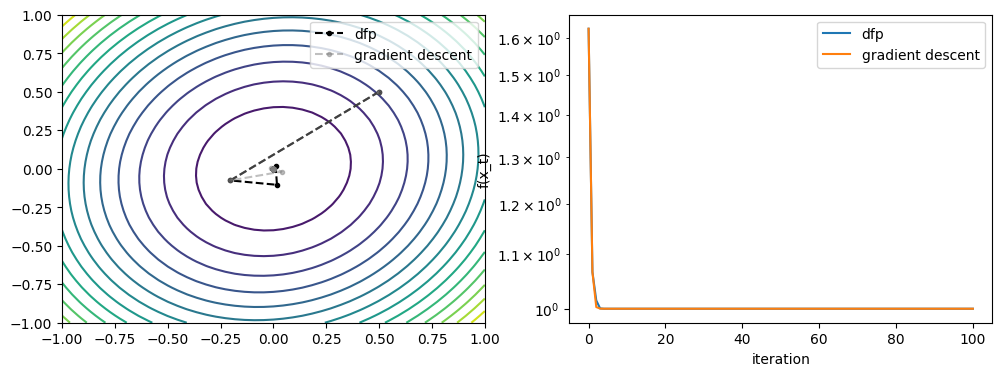

-- 0 --
g [  8. 180.]
d [  -8. -180.]
t alpha 0.022517998136852502
s [-0.18014399 -4.05323966]
y [  -0.36028797 -243.19437988]
new H [[ 1.00003072e+00 -7.40786259e-04]
 [-7.40786259e-04  1.66677641e-02]]
x [ 1.81985601 -1.05323966]
-- 1 --
g [  7.63971203 -63.19437988]
d [-7.68676029  1.05896841]
t alpha 0.8
s [-6.14940823  0.84717473]
y [-12.29881646  50.83048376]
new H [[0.53915341 0.00947346]
 [0.00947346 0.01895884]]
x [-4.32955221 -0.20606494]
-- 2 --
g [ -4.65910443 -12.36389612]
d [2.62910089 0.27854298]
t alpha 1.0
s [2.62910089 0.27854298]
y [ 5.25820178 16.71257892]
new H [[ 0.50346048 -0.00108875]
 [-0.00108875  0.01700922]]
x [-1.70045132  0.07247805]
-- 3 --
g [0.59909735 4.3486828 ]
d [-0.29688719 -0.07331542]
t alpha 1.0
s [-0.29688719 -0.07331542]
y [-0.59377439 -4.39892499]
new H [[ 0.50744912 -0.0010055 ]
 [-0.0010055   0.01680239]]
x [-1.99733852e+00 -8.37369835e-04]
-- 4 --
g [ 0.00532296 -0.05024219]
d [-0.00275165  0.00084954]
t alpha 1.0
s [-0.00275165  0.0008495

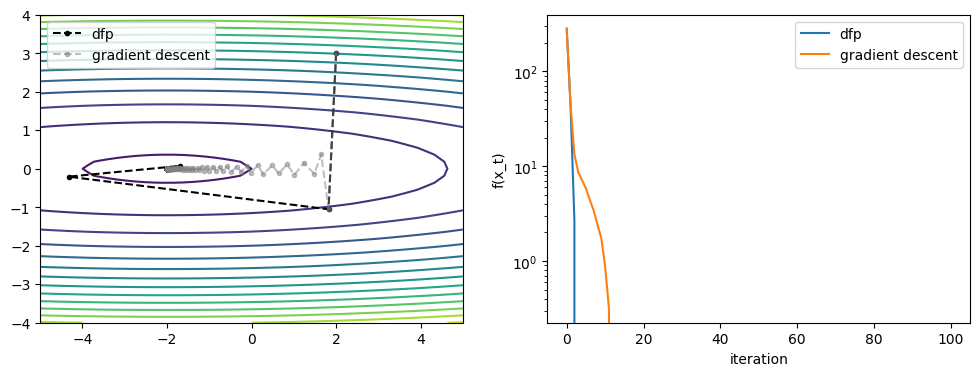

-- 0 --
g [2.79611726 2.34998073]
d [-2.79611726 -2.34998073]
t alpha 0.08589934592000005
s [-0.24018464 -0.20186181]
y [-3.51245302 -3.26850112]
new H [[ 0.50244201 -0.46645825]
 [-0.46645825  0.56303315]]
x [-0.04018464 -0.05186181]
-- 1 --
g [-0.71633576 -0.91852039]
d [-0.06853423  0.1830167 ]
t alpha 0.2097152000000001
s [-0.01437267  0.03838138]
y [-0.2482515   0.67613726]
new H [[0.07409794 0.00594887]
 [0.00594887 0.05894987]]
x [-0.05455731 -0.01348042]
-- 2 --
g [-0.96458726 -0.24238313]
d [0.07291584 0.02002666]
t alpha 1.0
s [0.07291584 0.02002666]
y [1.29437283 0.36018512]
new H [[ 0.05642597 -0.0003343 ]
 [-0.0003343   0.05680236]]
x [0.01835852 0.00654624]
-- 3 --
g [0.32978557 0.11780199]
d [-0.01856909 -0.00658118]
t alpha 1.0
s [-0.01856909 -0.00658118]
y [-0.33357578 -0.11843103]
new H [[ 0.05582239 -0.00043828]
 [-0.00043828  0.05680423]]
x [-2.10567623e-04 -3.49469678e-05]
-- 4 --
g [-0.00379022 -0.00062905]
d [2.11303215e-04 3.40712722e-05]
t alpha 1.0
s [2.113032

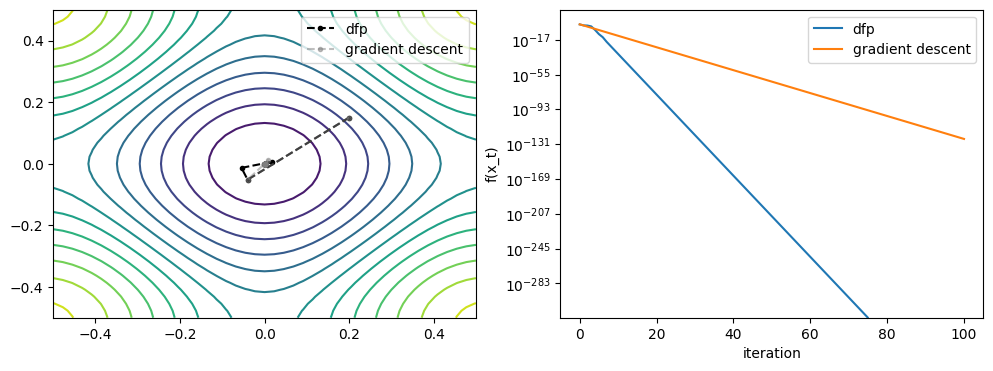

In [112]:
# run this to get plots
run_examples(
    optimizer_1=dfp_path,
    optimizer_name_1="dfp",
    optimizer_2=gradient_descent_path,
    optimizer_name_2="gradient descent",
)

## Task 2: BFGS method

Implement the BFGS method using the above provided backtracking line search.
* `x0` is the initial point.
* `f` is the function you are trying to minimize.
* `g` is the gradient of `f`.

Function `bfgs_path` should return a list of vectors on the path to the minimum.

### 1

In [113]:
def bfgs_path(
    x0: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    max_iter: int = 100,
) -> list[NDArray]:
    """Performs the BFGS (Broyden-Fletcher-Goldfarb-Shanno) quasi-Newton method.

    Args:
        x0 (NDArray): The starting point.
        f (Callable[[NDArray], float]): The objective function.
        g (Callable[[NDArray], NDArray]): The gradient of the objective function.
        max_iter (int, optional): The maximum number of steps. Defaults to 100.

    Returns:
        list[NDArray]: The list of points visited during the optimization.
    """
    # TODO: Implement BFGS quasi-Newton method using the provided backtracking line search

    # raise NotImplementedError
    eps = 0.000000001
    x = np.array(x0, dtype=float, copy=True)
    xs = [x0.copy()]
    # H = y.T @ s / np.outer(y, y.T) @ np.eye(x0.shape[0])
    H = np.eye(x0.shape[0])
    # Hs = [H] # first Hessian as identity; H=inv(B)
    for i in range(max_iter):
        print('--', i, '--')
        grad = g(x)
        print('g', grad)
        d = -H @ grad
        print('H', H)
        print('d', d)
        bls = backtracking_line_search(x, d, f, g)
        print('bls alpha t', bls)
        s = bls * d # delta x = alpha * Happrox * -grad
        print('s', s)
        x += s
        xs.append(x.copy())
        y = g(x) - grad
        print('y', y)
        if y.T @ s > eps:
            # break
            pass
        # else:
        if True:
            # H -= np.outer(H @ y, y.T) @ H.T / (y.T @ H @ y) + np.outer(s, s.T) / (y.T @ s)
            H = H - np.outer(H @ y, y.T) @ H.T / (y.T @ H @ y) + np.outer(s, s.T) / (y.T @ s)
            print('new H', H)
    return xs

-- 0 --
g [1.375 1.125]
H [[1. 0.]
 [0. 1.]]
d [-1.375 -1.125]
bls alpha t 0.5120000000000001
s [-0.704 -0.576]
y [-1.968 -1.264]
new H [[ 0.52654105 -0.26284239]
 [-0.26284239  0.86493182]]
-- 1 --
g [-0.593 -0.139]
H [[ 0.52654105 -0.26284239]
 [-0.26284239  0.86493182]]
d [ 0.27570375 -0.03564001]
bls alpha t 0.8
s [ 0.220563   -0.02851201]
y [ 0.668817   -0.12642078]
new H [[0.34293079 0.06956883]
 [0.06956883 0.59357988]]
-- 2 --
g [ 0.075817   -0.26542078]
H [[0.34293079 0.06956883]
 [0.06956883 0.59357988]]
d [-0.00753497  0.15227393]
bls alpha t 0.8
s [-0.00602798  0.12181915]
y [-0.04853871  0.30605486]
new H [[0.34350051 0.03478166]
 [0.03478166 0.40354662]]
-- 3 --
g [0.02727829 0.04063408]
H [[0.34350051 0.03478166]
 [0.03478166 0.40354662]]
d [-0.01078343 -0.01734653]
bls alpha t 1.0
s [-0.01078343 -0.01734653]
y [-0.02801365 -0.04067047]
new H [[0.33904352 0.03160969]
 [0.03160969 0.40474152]]
-- 4 --
g [-7.35360126e-04 -3.63878191e-05]
H [[0.33904352 0.03160969]
 [0.0316

C:\Users\admin\AppData\Local\Temp\ipykernel_17620\698500531.py:48: RuntimeWarning: invalid value encountered in divide
  H = H - np.outer(H @ y, y.T) @ H.T / (y.T @ H @ y) + np.outer(s, s.T) / (y.T @ s)


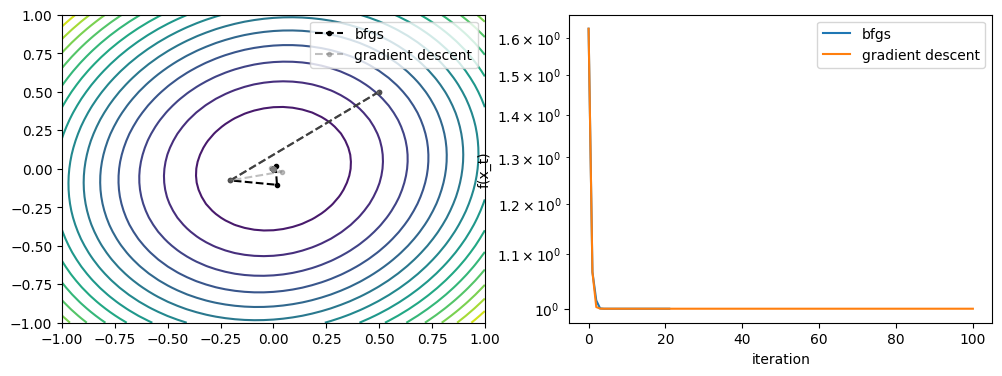

-- 0 --
g [  8. 180.]
H [[1. 0.]
 [0. 1.]]
d [  -8. -180.]
bls alpha t 0.022517998136852502
s [-0.18014399 -4.05323966]
y [  -0.36028797 -243.19437988]
new H [[ 1.00003072e+00 -7.40786259e-04]
 [-7.40786259e-04  1.66677641e-02]]
-- 1 --
g [  7.63971203 -63.19437988]
H [[ 1.00003072e+00 -7.40786259e-04]
 [-7.40786259e-04  1.66677641e-02]]
d [-7.68676029  1.05896841]
bls alpha t 0.8
s [-6.14940823  0.84717473]
y [-12.29881646  50.83048376]
new H [[0.53915341 0.00947346]
 [0.00947346 0.01895884]]
-- 2 --
g [ -4.65910443 -12.36389612]
H [[0.53915341 0.00947346]
 [0.00947346 0.01895884]]
d [2.62910089 0.27854298]
bls alpha t 1.0
s [2.62910089 0.27854298]
y [ 5.25820178 16.71257892]
new H [[ 0.50346048 -0.00108875]
 [-0.00108875  0.01700922]]
-- 3 --
g [0.59909735 4.3486828 ]
H [[ 0.50346048 -0.00108875]
 [-0.00108875  0.01700922]]
d [-0.29688719 -0.07331542]
bls alpha t 1.0
s [-0.29688719 -0.07331542]
y [-0.59377439 -4.39892499]
new H [[ 0.50744912 -0.0010055 ]
 [-0.0010055   0.01680239]]
-

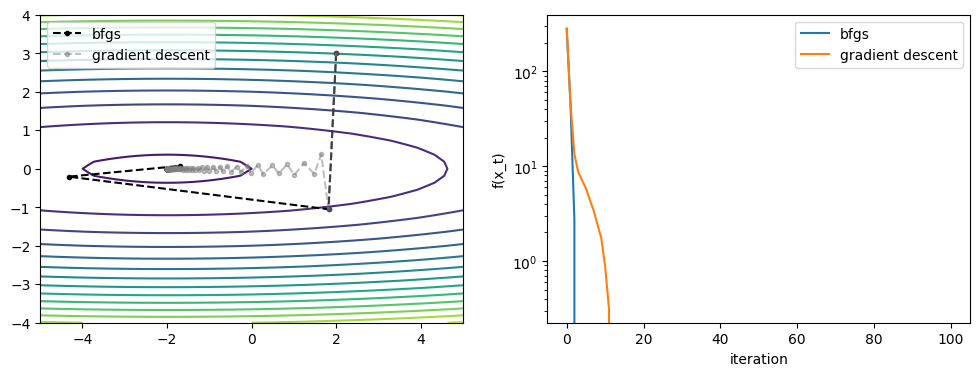

-- 0 --
g [2.79611726 2.34998073]
H [[1. 0.]
 [0. 1.]]
d [-2.79611726 -2.34998073]
bls alpha t 0.08589934592000005
s [-0.24018464 -0.20186181]
y [-3.51245302 -3.26850112]
new H [[ 0.50244201 -0.46645825]
 [-0.46645825  0.56303315]]
-- 1 --
g [-0.71633576 -0.91852039]
H [[ 0.50244201 -0.46645825]
 [-0.46645825  0.56303315]]
d [-0.06853423  0.1830167 ]
bls alpha t 0.2097152000000001
s [-0.01437267  0.03838138]
y [-0.2482515   0.67613726]
new H [[0.07409794 0.00594887]
 [0.00594887 0.05894987]]
-- 2 --
g [-0.96458726 -0.24238313]
H [[0.07409794 0.00594887]
 [0.00594887 0.05894987]]
d [0.07291584 0.02002666]
bls alpha t 1.0
s [0.07291584 0.02002666]
y [1.29437283 0.36018512]
new H [[ 0.05642597 -0.0003343 ]
 [-0.0003343   0.05680236]]
-- 3 --
g [0.32978557 0.11780199]
H [[ 0.05642597 -0.0003343 ]
 [-0.0003343   0.05680236]]
d [-0.01856909 -0.00658118]
bls alpha t 1.0
s [-0.01856909 -0.00658118]
y [-0.33357578 -0.11843103]
new H [[ 0.05582239 -0.00043828]
 [-0.00043828  0.05680423]]
-- 4 --

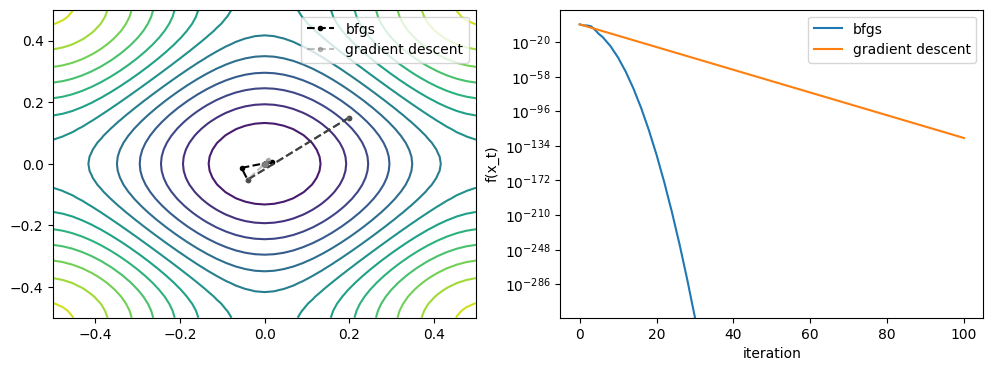

In [114]:
# run this to get plots
run_examples(
    optimizer_1=bfgs_path,
    optimizer_name_1="bfgs",
    optimizer_2=gradient_descent_path,
    optimizer_name_2="gradient descent",
)

### 2

In [115]:
def bfgs_path(
    x0: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    max_iter: int = 100,
) -> list[NDArray]:
    """Performs the BFGS (Broyden-Fletcher-Goldfarb-Shanno) quasi-Newton method."""
    path = [x0]
    n = len(x0)
    H = np.eye(n)  # initial inverse Hessian approximation
    
    x = x0
    grad = g(x)
    
    for i in range(max_iter):
        print('--', i, '--')
        if np.linalg.norm(grad) < 1e-6:  # stopping condition
            break
            # pass
        
        # Step direction
        d = -H @ grad
        print('d', d)
        
        # Line search
        step_size = backtracking_line_search(x, d, f, g)
        print('t alpha', step_size)
        
        # Update x
        x_new = x + step_size * d
        grad_new = g(x_new)
        
        # BFGS update
        s = x_new - x
        y = grad_new - grad
        print('s', s)
        print('y', y)
        
        if y.T @ s > 1e-10:  # curvature condition
        # if True:
            rho = 1.0 / (y.T @ s)
            print('rho', rho)
            I = np.eye(n)
            V = I - rho * np.outer(s, y)
            H = V @ H @ V.T + rho * np.outer(s, s) # inaczej
            print('Ha', H)
            H = (I - rho * np.outer(s, y.T)) @ H @ (I - rho * np.outer(y, s.T)) + rho * np.outer(s, s.T)
            print('Hb', H)
        
        # Prepare next iteration
        x, grad = x_new, grad_new
        path.append(x)
    
    return path

-- 0 --
d [-1.375 -1.125]
t alpha 0.5120000000000001
s [-0.704 -0.576]
y [-1.968 -1.264]
rho 0.47314074612403073
Ha [[ 0.5304242  -0.26888831]
 [-0.26888831  0.87434509]]
Hb [[ 0.5304242  -0.26888831]
 [-0.26888831  0.87434509]]
-- 1 --
d [ 0.27716607 -0.0379168 ]
t alpha 0.8
s [ 0.22173286 -0.03033344]
y [ 0.67278194 -0.13126681]
rho 6.529135361878233
Ha [[0.35028607 0.10614472]
 [0.10614472 0.77510598]]
Hb [[0.35028607 0.10614472]
 [0.10614472 0.77510598]]
-- 2 --
d [0.00074089 0.20101699]
t alpha 0.6400000000000001
s [0.00047417 0.12865087]
y [-0.0307402   0.32150864]
rho 24.185088228332436
Ha [[0.34976606 0.0349168 ]
 [0.0349168  0.40348596]]
Hb [[0.34976606 0.0349168 ]
 [0.0349168  0.40348596]]
-- 3 --
d [-0.01894234 -0.02238774]
t alpha 1.0
s [-0.01894234 -0.02238774]
y [-0.05123007 -0.05123377]
rho 472.27164771566385
Ha [[0.33951348 0.03023466]
 [0.03023466 0.40673988]]
Hb [[0.33951348 0.03023466]
 [0.03023466 0.40673988]]
-- 4 --
d [7.42725442e-04 6.28829720e-05]
t alpha 1.0
s 

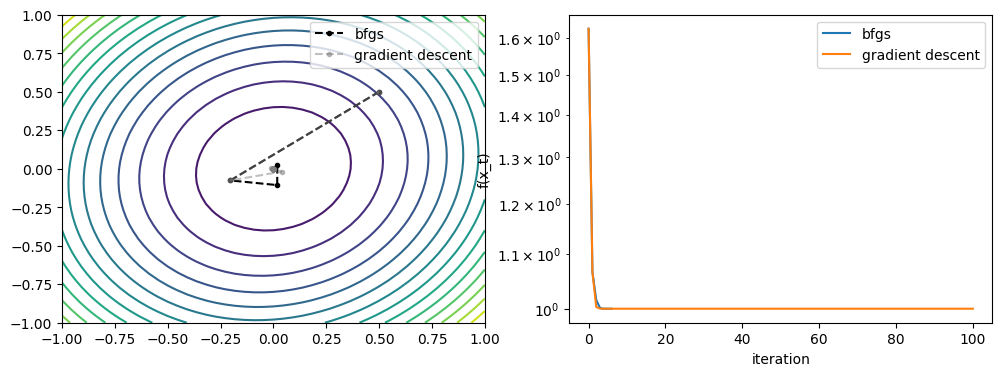

-- 0 --
d [  -8. -180.]
t alpha 0.022517998136852502
s [-0.18014399 -4.05323966]
y [  -0.36028797 -243.19437988]
rho 0.0010144148240509505
Ha [[ 1.00187629e+00 -7.43520435e-04]
 [-7.43520435e-04  1.66677682e-02]]
Hb [[ 1.00187629e+00 -7.43520435e-04]
 [-7.43520435e-04  1.66677682e-02]]
-- 1 --
d [-7.70103269  1.05898956]
t alpha 0.8
s [-6.16082615  0.84719164]
y [-12.3216523   50.83149869]
rho 0.008405086245202377
Ha [[0.56434306 0.01559688]
 [0.01559688 0.02044738]]
Hb [[0.56434306 0.01559688]
 [0.01559688 0.02044738]]
-- 2 --
d [2.83504292 0.32581221]
t alpha 1.0
s [2.83504292 0.32581221]
y [ 5.67008583 19.54873231]
rho 0.04455503546096793
Ha [[ 0.50637569 -0.00184926]
 [-0.00184926  0.01720304]]
Hb [[ 0.50637569 -0.00184926]
 [-0.00184926  0.01720304]]
-- 3 --
d [-0.48708438 -0.12179116]
t alpha 1.0
s [-0.48708438 -0.12179116]
y [-0.97416876 -7.30746979]
rho 0.7328758278655816
Ha [[ 0.51265501 -0.00168706]
 [-0.00168706  0.01689157]]
Hb [[ 0.51265501 -0.00168706]
 [-0.00168706  0.01

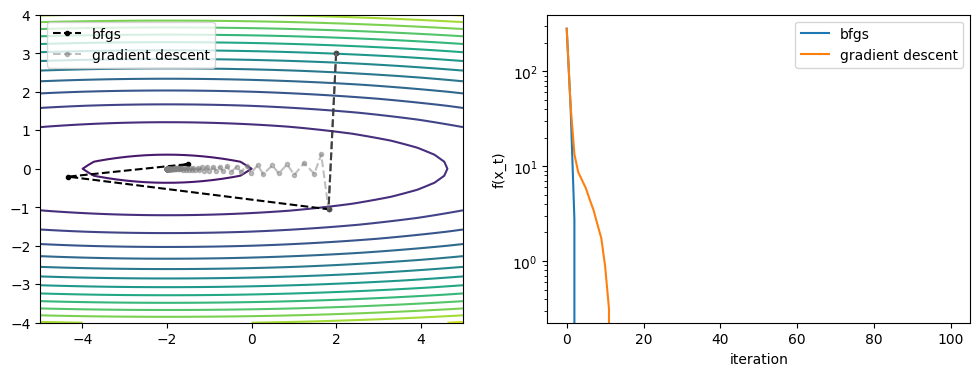

-- 0 --
d [-2.79611726 -2.34998073]
t alpha 0.08589934592000005
s [-0.24018464 -0.20186181]
y [-3.51245302 -3.26850112]
rho 0.6651488765612567
Ha [[ 0.50362834 -0.46773312]
 [-0.46773312  0.56440318]]
Hb [[ 0.50362834 -0.46773312]
 [-0.46773312  0.56440318]]
-- 1 --
d [-0.06885542  0.18336186]
t alpha 0.2097152000000001
s [-0.01444003  0.03845377]
y [-0.24939948  0.67743595]
rho 33.72533215848578
Ha [[0.1860474  0.04717803]
 [0.04717803 0.07413239]]
Hb [[0.1860474  0.04717803]
 [0.04717803 0.07413239]]
-- 2 --
d [0.19104642 0.06343366]
t alpha 0.32768000000000014
s [0.06260209 0.02078594]
y [1.10927398 0.37384332]
rho 12.951093828121442
Ha [[ 0.05657223 -0.00040661]
 [-0.00040661  0.05680716]]
Hb [[ 0.05657223 -0.00040661]
 [-0.00040661  0.05680716]]
-- 3 --
d [-0.00806633 -0.00748329]
t alpha 1.0
s [-0.00806633 -0.00748329]
y [-0.14513903 -0.13465588]
rho 459.0508734336511
Ha [[ 0.05628387 -0.00076239]
 [-0.00076239  0.0563952 ]]
Hb [[ 0.05628387 -0.00076239]
 [-0.00076239  0.0563952 

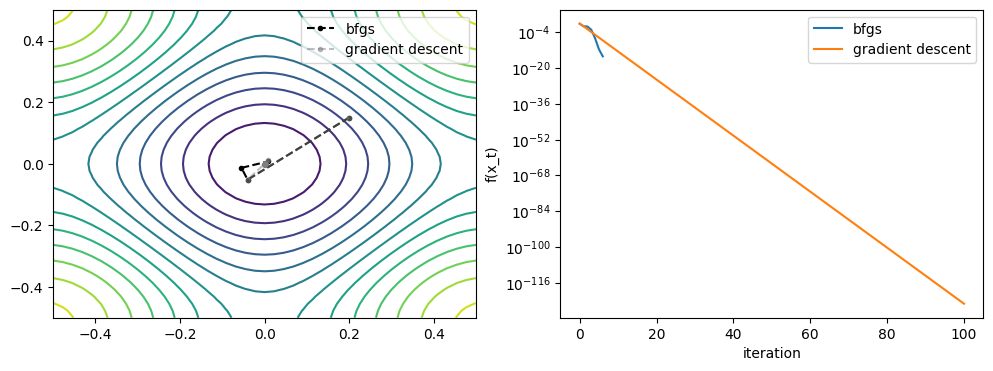

In [116]:
# run this to get plots
run_examples(
    optimizer_1=bfgs_path,
    optimizer_name_1="bfgs",
    optimizer_2=gradient_descent_path,
    optimizer_name_2="gradient descent",
)

### 3

In [117]:
def bfgs_path(
    x0: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    max_iter: int = 100,
) -> list[NDArray]:
    """Performs the BFGS (Broyden-Fletcher-Goldfarb-Shanno) quasi-Newton method."""
    path = [x0]
    n = len(x0)
    H = np.eye(n)  # initial inverse Hessian approximation
    
    x = x0
    grad = g(x)
    
    for i in range(max_iter):
        print('--', i, '--')
        if np.linalg.norm(grad) < 1e-6:  # stopping condition
            # break
            pass
        
        # Step direction
        d = -H @ grad
        print('d', d)
        
        # Line search
        step_size = backtracking_line_search(x, d, f, g)
        print('t alpha', step_size)
        
        # Update x
        x_new = x + step_size * d
        grad_new = g(x_new)
        
        # BFGS update
        s = x_new - x
        y = grad_new - grad
        print('s', s)
        print('y', y)
        
        # if y.T @ s > 1e-10:  # curvature condition
        if True:
            rho = 1.0 / (y.T @ s)
            print('rho', rho)
            I = np.eye(n)
            V = I - rho * np.outer(s, y)
            H = V @ H @ V.T + rho * np.outer(s, s) # inaczej
            print('Ha', H)
            H = (I - rho * np.outer(s, y.T)) @ H @ (I - rho * np.outer(y, s.T)) + rho * np.outer(s, s.T)
            print('Hb', H)
        
        # Prepare next iteration
        x, grad = x_new, grad_new
        path.append(x)
    
    return path

-- 0 --
d [-1.375 -1.125]
t alpha 0.5120000000000001
s [-0.704 -0.576]
y [-1.968 -1.264]
rho 0.47314074612403073
Ha [[ 0.5304242  -0.26888831]
 [-0.26888831  0.87434509]]
Hb [[ 0.5304242  -0.26888831]
 [-0.26888831  0.87434509]]
-- 1 --
d [ 0.27716607 -0.0379168 ]
t alpha 0.8
s [ 0.22173286 -0.03033344]
y [ 0.67278194 -0.13126681]
rho 6.529135361878233
Ha [[0.35028607 0.10614472]
 [0.10614472 0.77510598]]
Hb [[0.35028607 0.10614472]
 [0.10614472 0.77510598]]
-- 2 --
d [0.00074089 0.20101699]
t alpha 0.6400000000000001
s [0.00047417 0.12865087]
y [-0.0307402   0.32150864]
rho 24.185088228332436
Ha [[0.34976606 0.0349168 ]
 [0.0349168  0.40348596]]
Hb [[0.34976606 0.0349168 ]
 [0.0349168  0.40348596]]
-- 3 --
d [-0.01894234 -0.02238774]
t alpha 1.0
s [-0.01894234 -0.02238774]
y [-0.05123007 -0.05123377]
rho 472.27164771566385
Ha [[0.33951348 0.03023466]
 [0.03023466 0.40673988]]
Hb [[0.33951348 0.03023466]
 [0.03023466 0.40673988]]
-- 4 --
d [7.42725442e-04 6.28829720e-05]
t alpha 1.0
s 

C:\Users\admin\AppData\Local\Temp\ipykernel_17620\2917145233.py:41: RuntimeWarning: overflow encountered in scalar divide
  rho = 1.0 / (y.T @ s)
C:\Users\admin\AppData\Local\Temp\ipykernel_17620\2917145233.py:22: RuntimeWarning: invalid value encountered in matmul
  d = -H @ grad


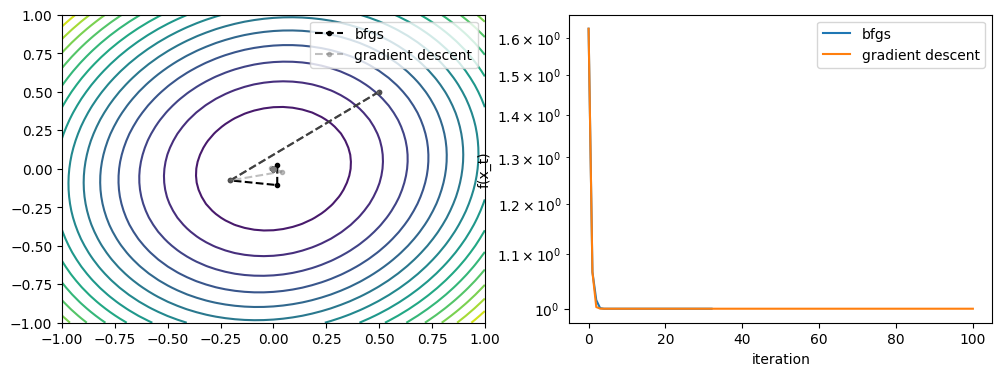

-- 0 --
d [  -8. -180.]
t alpha 0.022517998136852502
s [-0.18014399 -4.05323966]
y [  -0.36028797 -243.19437988]
rho 0.0010144148240509505
Ha [[ 1.00187629e+00 -7.43520435e-04]
 [-7.43520435e-04  1.66677682e-02]]
Hb [[ 1.00187629e+00 -7.43520435e-04]
 [-7.43520435e-04  1.66677682e-02]]
-- 1 --
d [-7.70103269  1.05898956]
t alpha 0.8
s [-6.16082615  0.84719164]
y [-12.3216523   50.83149869]
rho 0.008405086245202377
Ha [[0.56434306 0.01559688]
 [0.01559688 0.02044738]]
Hb [[0.56434306 0.01559688]
 [0.01559688 0.02044738]]
-- 2 --
d [2.83504292 0.32581221]
t alpha 1.0
s [2.83504292 0.32581221]
y [ 5.67008583 19.54873231]
rho 0.04455503546096793
Ha [[ 0.50637569 -0.00184926]
 [-0.00184926  0.01720304]]
Hb [[ 0.50637569 -0.00184926]
 [-0.00184926  0.01720304]]
-- 3 --
d [-0.48708438 -0.12179116]
t alpha 1.0
s [-0.48708438 -0.12179116]
y [-0.97416876 -7.30746979]
rho 0.7328758278655816
Ha [[ 0.51265501 -0.00168706]
 [-0.00168706  0.01689157]]
Hb [[ 0.51265501 -0.00168706]
 [-0.00168706  0.01

C:\Users\admin\AppData\Local\Temp\ipykernel_17620\2917145233.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  rho = 1.0 / (y.T @ s)
C:\Users\admin\AppData\Local\Temp\ipykernel_17620\2917145233.py:44: RuntimeWarning: invalid value encountered in multiply
  V = I - rho * np.outer(s, y)
C:\Users\admin\AppData\Local\Temp\ipykernel_17620\2917145233.py:45: RuntimeWarning: invalid value encountered in multiply
  H = V @ H @ V.T + rho * np.outer(s, s) # inaczej
C:\Users\admin\AppData\Local\Temp\ipykernel_17620\2917145233.py:47: RuntimeWarning: invalid value encountered in multiply
  H = (I - rho * np.outer(s, y.T)) @ H @ (I - rho * np.outer(y, s.T)) + rho * np.outer(s, s.T)


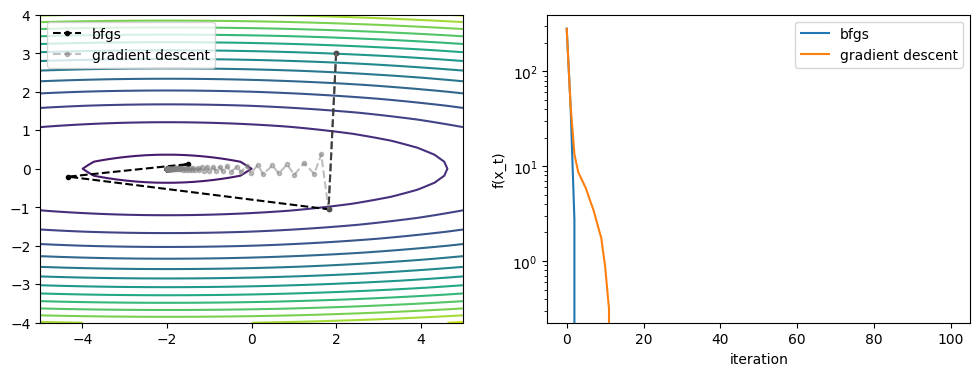

-- 0 --
d [-2.79611726 -2.34998073]
t alpha 0.08589934592000005
s [-0.24018464 -0.20186181]
y [-3.51245302 -3.26850112]
rho 0.6651488765612567
Ha [[ 0.50362834 -0.46773312]
 [-0.46773312  0.56440318]]
Hb [[ 0.50362834 -0.46773312]
 [-0.46773312  0.56440318]]
-- 1 --
d [-0.06885542  0.18336186]
t alpha 0.2097152000000001
s [-0.01444003  0.03845377]
y [-0.24939948  0.67743595]
rho 33.72533215848578
Ha [[0.1860474  0.04717803]
 [0.04717803 0.07413239]]
Hb [[0.1860474  0.04717803]
 [0.04717803 0.07413239]]
-- 2 --
d [0.19104642 0.06343366]
t alpha 0.32768000000000014
s [0.06260209 0.02078594]
y [1.10927398 0.37384332]
rho 12.951093828121442
Ha [[ 0.05657223 -0.00040661]
 [-0.00040661  0.05680716]]
Hb [[ 0.05657223 -0.00040661]
 [-0.00040661  0.05680716]]
-- 3 --
d [-0.00806633 -0.00748329]
t alpha 1.0
s [-0.00806633 -0.00748329]
y [-0.14513903 -0.13465588]
rho 459.0508734336511
Ha [[ 0.05628387 -0.00076239]
 [-0.00076239  0.0563952 ]]
Hb [[ 0.05628387 -0.00076239]
 [-0.00076239  0.0563952 

C:\Users\admin\AppData\Local\Temp\ipykernel_17620\2917145233.py:45: RuntimeWarning: invalid value encountered in matmul
  H = V @ H @ V.T + rho * np.outer(s, s) # inaczej


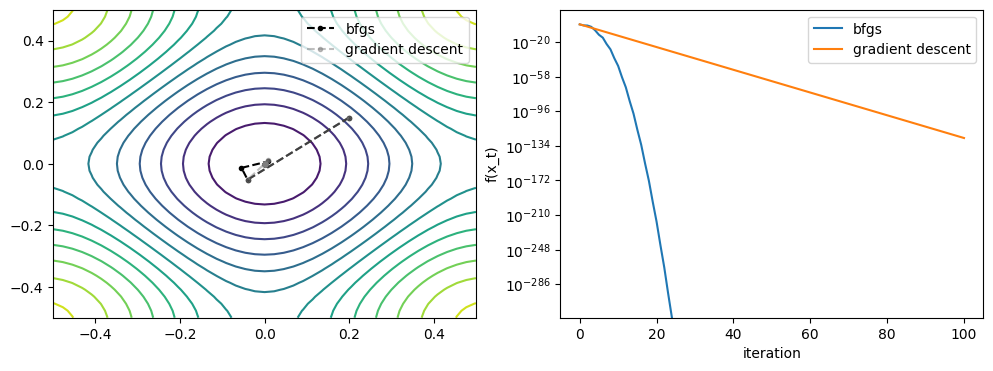

In [118]:
# run this to get plots
run_examples(
    optimizer_1=bfgs_path,
    optimizer_name_1="bfgs",
    optimizer_2=gradient_descent_path,
    optimizer_name_2="gradient descent",
)

### 4

In [126]:
def bfgs_path(
    x0: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    max_iter: int = 100,
) -> list[NDArray]:
    """Performs the BFGS (Broyden-Fletcher-Goldfarb-Shanno) quasi-Newton method.

    Args:
        x0 (NDArray): The starting point.
        f (Callable[[NDArray], float]): The objective function.
        g (Callable[[NDArray], NDArray]): The gradient of the objective function.
        max_iter (int, optional): The maximum number of steps. Defaults to 100.

    Returns:
        list[NDArray]: The list of points visited during the optimization.
    """
    # TODO: Implement BFGS quasi-Newton method using the provided backtracking line search

    # raise NotImplementedError
    eps = 1e-6
    x = np.array(x0, dtype=float, copy=True)
    xs = [x0.copy()]
    I = np.eye(x0.shape[0])
    H = I.copy() # inv(B)
    for i in range(max_iter):
        print('--', i, '--')
        grad = g(x)
        print('g', grad)
        d = -H @ grad
        print('d', d)
        bls = backtracking_line_search(x, d, f, g)
        print('t alpha', bls)
        s = bls * d # delta x = alpha * Happrox * -grad
        print('s', s)
        x += s
        xs.append(x.copy())
        y = g(x) - grad
        print('y', y)
        if (s.T @ y) > eps: # the curvature condition for B psd (hence H existing)
            rho = 1.0 / (y.T @ s)
            print('rho', rho)
            H = (I - rho * np.outer(s, y.T)) @ H @ (I - rho * np.outer(y, s.T)) + rho * np.outer(s, s.T)
            # H = H - np.outer(H @ y, y.T) @ H.T / (y.T @ H @ y) + np.outer(s, s.T) / (y.T @ s)
            print('new H', H)
        else:
            print('skip due to curvature condition for psd-H')
        print('x', x)

    return xs

-- 0 --
g [1.375 1.125]
d [-1.375 -1.125]
t alpha 0.5120000000000001
s [-0.704 -0.576]
y [-1.968 -1.264]
rho 0.47314074612403073
new H [[ 0.5304242  -0.26888831]
 [-0.26888831  0.87434509]]
x [-0.204 -0.076]
-- 1 --
g [-0.593 -0.139]
d [ 0.27716607 -0.0379168 ]
t alpha 0.8
s [ 0.22173286 -0.03033344]
y [ 0.67278194 -0.13126681]
rho 6.529135361878233
new H [[0.35028607 0.10614472]
 [0.10614472 0.77510598]]
x [ 0.01773286 -0.10633344]
-- 2 --
g [ 0.07978194 -0.27026681]
d [0.00074089 0.20101699]
t alpha 0.6400000000000001
s [0.00047417 0.12865087]
y [-0.0307402   0.32150864]
rho 24.18508822833243
new H [[0.34976606 0.0349168 ]
 [0.0349168  0.40348596]]
x [0.01820703 0.02231744]
-- 3 --
g [0.04904174 0.05124183]
d [-0.01894234 -0.02238774]
t alpha 1.0
s [-0.01894234 -0.02238774]
y [-0.05123007 -0.05123377]
rho 472.2716477156635
new H [[0.33951348 0.03023466]
 [0.03023466 0.40673988]]
x [-7.35303751e-04 -7.03041277e-05]
-- 4 --
g [-2.18833522e-03  8.06561870e-06]
d [7.42725442e-04 6.288297

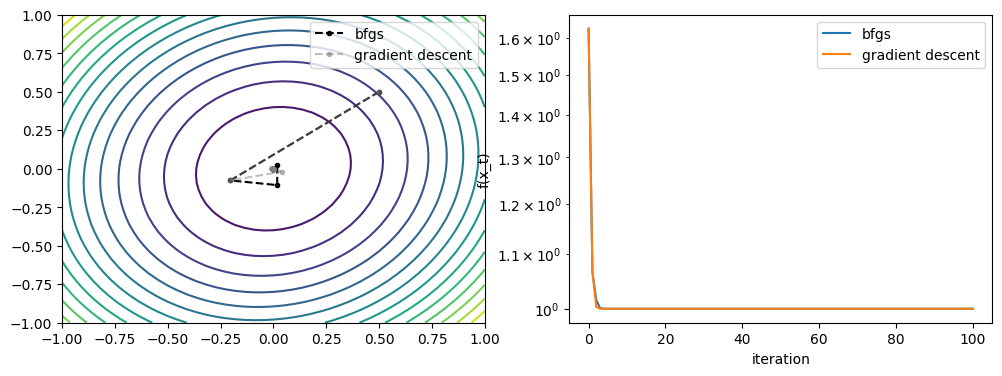

-- 0 --
g [  8. 180.]
d [  -8. -180.]
t alpha 0.022517998136852502
s [-0.18014399 -4.05323966]
y [  -0.36028797 -243.19437988]
rho 0.0010144148240509505
new H [[ 1.00187629e+00 -7.43520435e-04]
 [-7.43520435e-04  1.66677682e-02]]
x [ 1.81985601 -1.05323966]
-- 1 --
g [  7.63971203 -63.19437988]
d [-7.70103269  1.05898956]
t alpha 0.8
s [-6.16082615  0.84719164]
y [-12.3216523   50.83149869]
rho 0.008405086245202377
new H [[0.56434306 0.01559688]
 [0.01559688 0.02044738]]
x [-4.34097014 -0.20604802]
-- 2 --
g [ -4.68194027 -12.36288119]
d [2.83504292 0.32581221]
t alpha 1.0
s [2.83504292 0.32581221]
y [ 5.67008583 19.54873231]
rho 0.044555035460967944
new H [[ 0.50637569 -0.00184926]
 [-0.00184926  0.01720304]]
x [-1.50592722  0.11976419]
-- 3 --
g [0.98814556 7.18585112]
d [-0.48708438 -0.12179116]
t alpha 1.0
s [-0.48708438 -0.12179116]
y [-0.97416876 -7.30746979]
rho 0.7328758278655826
new H [[ 0.51265501 -0.00168706]
 [-0.00168706  0.01689157]]
x [-1.9930116  -0.00202698]
-- 4 --
g 

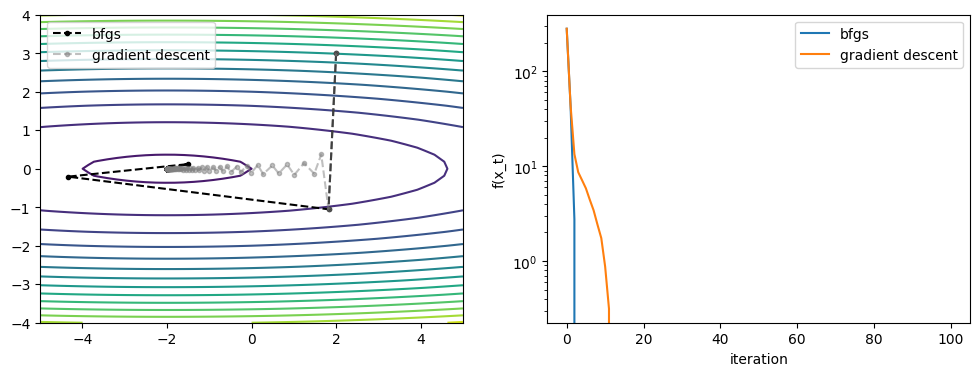

-- 0 --
g [2.79611726 2.34998073]
d [-2.79611726 -2.34998073]
t alpha 0.08589934592000005
s [-0.24018464 -0.20186181]
y [-3.51245302 -3.26850112]
rho 0.6651488765612567
new H [[ 0.50362834 -0.46773312]
 [-0.46773312  0.56440318]]
x [-0.04018464 -0.05186181]
-- 1 --
g [-0.71633576 -0.91852039]
d [-0.06885542  0.18336186]
t alpha 0.2097152000000001
s [-0.01444003  0.03845377]
y [-0.24939948  0.67743595]
rho 33.72533215848577
new H [[0.1860474  0.04717803]
 [0.04717803 0.07413239]]
x [-0.05462467 -0.01340804]
-- 2 --
g [-0.96573524 -0.24108443]
d [0.19104642 0.06343366]
t alpha 0.32768000000000014
s [0.06260209 0.02078594]
y [1.10927398 0.37384332]
rho 12.951093828121447
new H [[ 0.05657223 -0.00040661]
 [-0.00040661  0.05680716]]
x [0.00797742 0.0073779 ]
-- 3 --
g [0.14353873 0.13275888]
d [-0.00806633 -0.00748329]
t alpha 1.0
s [-0.00806633 -0.00748329]
y [-0.14513903 -0.13465588]
rho 459.0508734336514
new H [[ 0.05628387 -0.00076239]
 [-0.00076239  0.0563952 ]]
x [-8.89053399e-05 -1.0

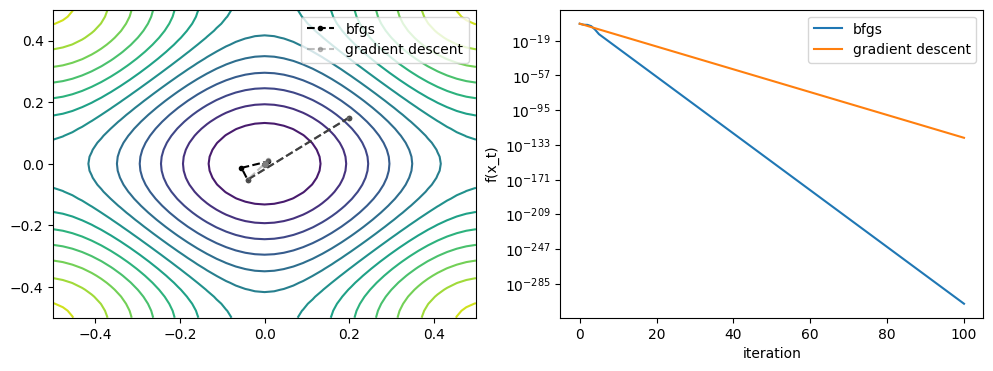

In [127]:
# run this to get plots
run_examples(
    optimizer_1=bfgs_path,
    optimizer_name_1="bfgs",
    optimizer_2=gradient_descent_path,
    optimizer_name_2="gradient descent",
)

## Task 3: Error plots

Then compare and plot the error over time for the optimization methods on the following tasks.
Implementations of the prior methods are given in the Utils section.

In [121]:
def plot_error(
    x0: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    h: Callable[[NDArray], NDArray],
    x_star: NDArray,
) -> None:
    """Compares the difference between optimum and function value along the paths of gradient descent, heavy ball and Nesterov's method.

    Args:
        x0 (NDArray): The starting point.
        f (Callable[[NDArray], float]): The objective function.
        g (Callable[[NDArray], NDArray]): The gradient of the objective function.
        x_star (NDArray): The optimal solution.
    """
    ball = heavy_ball_path(x0, f, g)
    nest = nag_path(x0, f, g)
    gd = gradient_descent_path(x0, f, g)
    newt = newtons_path(x0, f, g, h)
    dfp = dfp_path(x0, f, g)
    bfgs = bfgs_path(x0, f, g)

    def errors(path: list[NDArray]) -> NDArray:
        return np.array([f(x) for x in path]) - f(x_star)

    plt.semilogy(
        np.arange(len(gd)),
        errors(gd),
        label="gradient descent",
    )
    plt.semilogy(
        np.arange(len(ball)),
        errors(ball),
        label="heavy ball",
    )
    plt.semilogy(
        np.arange(len(nest)),
        errors(nest),
        label="nesterov",
    )
    plt.semilogy(
        np.arange(len(newt)),
        errors(newt),
        label="newton's",
    )
    plt.semilogy(
        np.arange(len(dfp)),
        errors(dfp),
        label="dfp",
    )
    plt.semilogy(
        np.arange(len(bfgs)),
        errors(bfgs),
        label="bfgs",
    )

    plt.legend()
    plt.show()

### Simple quadratic function

-- 0 --
g [  8. 180.]
d [  -8. -180.]
t alpha 0.022517998136852502
s [-0.18014399 -4.05323966]
y [  -0.36028797 -243.19437988]
new H [[ 1.00003072e+00 -7.40786259e-04]
 [-7.40786259e-04  1.66677641e-02]]
x [ 1.81985601 -1.05323966]
-- 1 --
g [  7.63971203 -63.19437988]
d [-7.68676029  1.05896841]
t alpha 0.8
s [-6.14940823  0.84717473]
y [-12.29881646  50.83048376]
new H [[0.53915341 0.00947346]
 [0.00947346 0.01895884]]
x [-4.32955221 -0.20606494]
-- 2 --
g [ -4.65910443 -12.36389612]
d [2.62910089 0.27854298]
t alpha 1.0
s [2.62910089 0.27854298]
y [ 5.25820178 16.71257892]
new H [[ 0.50346048 -0.00108875]
 [-0.00108875  0.01700922]]
x [-1.70045132  0.07247805]
-- 3 --
g [0.59909735 4.3486828 ]
d [-0.29688719 -0.07331542]
t alpha 1.0
s [-0.29688719 -0.07331542]
y [-0.59377439 -4.39892499]
new H [[ 0.50744912 -0.0010055 ]
 [-0.0010055   0.01680239]]
x [-1.99733852e+00 -8.37369835e-04]
-- 4 --
g [ 0.00532296 -0.05024219]
d [-0.00275165  0.00084954]
t alpha 1.0
s [-0.00275165  0.0008495

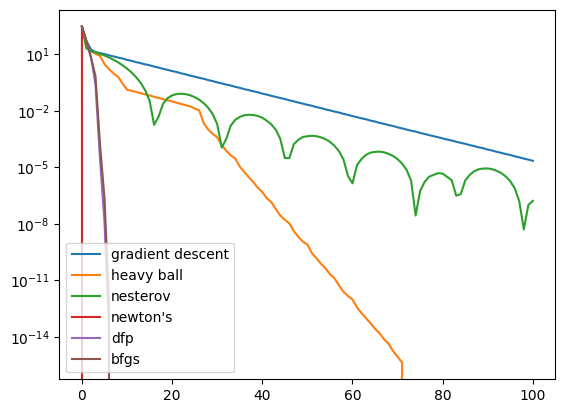

In [122]:
def f(x):
    return x[0] ** 2 + 30 * x[1] ** 2 + 4 * x[0]


def g(x):
    return np.array([2 * x[0] + 4, 60 * x[1]])


def h(x):
    return np.array([[2, 0], [0, 60]])


x0 = np.array([2.0, 3.0])
x_star = np.array([-2.0, 0.0])

plot_error(x0, f, g, h, x_star)

### Ill-conditioned quadratic

-- 0 --
g [-0.55307679 -0.2489136  -1.00866836 -0.48445344 -1.21772519 -0.91942368
 -1.52170045 -0.35879608 -0.9052594   0.30712707  0.60146081 -1.70676764
 -0.21620468 -0.80488057 -0.12374001  0.58651565 -0.01098289 -1.43599402
 -0.55524007  1.71147316  0.21524446 -1.78229379  0.21379686  1.80047869
 -1.89304889 -0.68239251  0.07001286  0.37141774 -1.08235193  0.5419834
 -1.14825642 -0.54219529 -0.24468193 -0.14551481  0.17496804 -1.04564012
  0.86534283  1.62192513 -0.61444012 -0.63123833 -0.48024115 -0.40772837
  0.32054038 -0.7874827   0.04555813  0.48711356  0.31189131 -2.0206397
  1.73497608 -0.4997881 ]
d [ 0.55307679  0.2489136   1.00866836  0.48445344  1.21772519  0.91942368
  1.52170045  0.35879608  0.9052594  -0.30712707 -0.60146081  1.70676764
  0.21620468  0.80488057  0.12374001 -0.58651565  0.01098289  1.43599402
  0.55524007 -1.71147316 -0.21524446  1.78229379 -0.21379686 -1.80047869
  1.89304889  0.68239251 -0.07001286 -0.37141774  1.08235193 -0.5419834
  1.14825642  0.

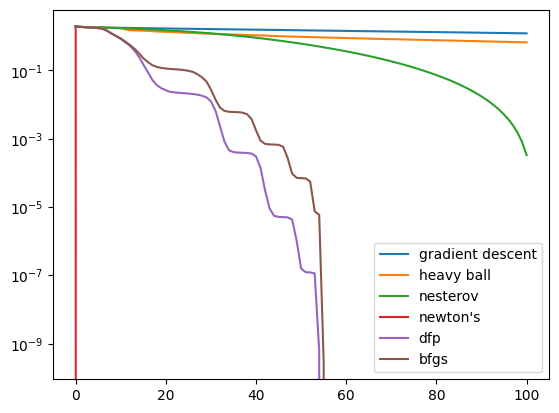

In [123]:
n = 50
rng = np.random.default_rng(seed=42)
Q = rng.standard_normal((n, n))
Q = Q.T @ Q
U, _ = np.linalg.qr(Q)

A = U @ np.diag(np.linspace(1, 1000, n)) @ U.T
b = rng.standard_normal(n)


def f(x):
    return 0.5 * x.T @ A @ x - b.T @ x


def g(x):
    return A @ x - b


def h(x):
    return A


x0 = np.zeros(n)
x_star = np.linalg.solve(A, b)

plot_error(x0, f, g, h, x_star)

### Linear regression

-- 0 --
g [-9.71102720e+01 -6.25073305e+01 -1.17593814e+01 -4.82762320e+01
 -2.67188910e+00 -1.16303916e+01  2.99868882e+01 -2.03470554e+02
 -1.85510360e+01 -3.67093966e+01 -1.69005194e+02 -2.06523152e+01
 -2.30928957e+01 -3.08919972e+01  7.89029198e+00 -3.88561357e+01
  6.55193849e-01 -3.59946079e+01  1.88265894e+00 -1.95065771e+02
 -1.36375745e+01 -6.73714289e+01  2.78624747e+01 -3.31198473e+01
  1.74927789e+01 -3.80209707e+00  3.92838102e-01 -3.18691314e+01
 -1.89198521e+02 -1.89197223e+02  4.45131242e+00  1.31630877e+01
 -2.16486260e+01 -3.10507043e+01 -3.96302781e+01 -8.44419280e+01
  7.10421771e+01  1.31442540e+01 -3.72021036e+01 -3.82372006e+00
 -2.46246357e+01  2.19236297e+01  3.05533233e+01  1.61874727e+01
  5.17195050e+01 -4.50010595e+01 -9.65326311e+01  2.30121950e+01
 -1.06355972e+02 -2.33560492e+01 -9.26677542e+00 -7.61603442e+01
 -3.94521810e+01 -1.42456514e+01 -1.31580337e+02  2.00865829e+01
 -1.61057034e+02  7.76950653e-02 -1.91624287e+01 -1.93672036e+02
 -1.98911472e+0

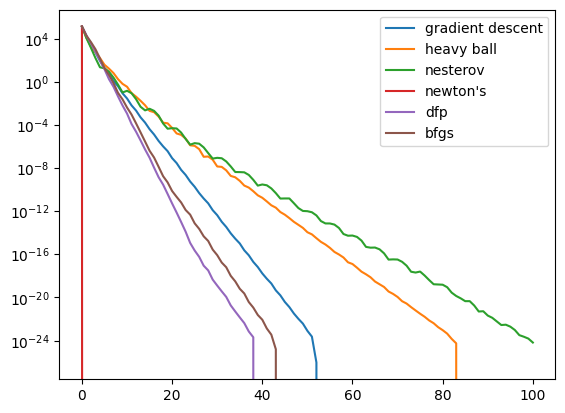

In [124]:
def f(w):
    return np.linalg.norm(X @ w - y) ** 2 / len(X)


def g(w):
    return 2 * X.T @ (X @ w - y) / len(X)


def h(w):
    return 2 * X.T @ X / len(X)


X, y = make_regression(n_samples=1000, n_features=100, n_informative=40, random_state=0)
x0 = np.zeros(100)

x_star = np.linalg.lstsq(X, y, rcond=None)[0]

plot_error(x0, f, g, h, x_star)

### Logistic regression


-- 0 --
g [-2.24840557e-01  2.22897130e-02 -1.30100013e-02  1.09714580e-02
  1.20343619e-02 -6.87997931e-03  3.73144600e-02 -2.45798112e-01
 -2.75329593e-01 -1.27835576e-02  1.09133930e-02 -4.65715234e-02
 -2.72454754e-01 -2.31143251e-01  3.38853204e-04  1.83993485e-02
 -1.04080219e-03 -2.52024128e-01 -3.89355419e-03 -2.69346729e-02
 -1.60951291e-02 -4.17157449e-03  2.60566754e-02  1.44420531e-02
  3.89690793e-03 -3.03501733e-02  6.63009219e-03  3.07079280e-01
  2.18370083e-01 -2.47462482e-01 -1.96847251e-01  5.22307329e-03
 -3.53053043e-02 -6.90770355e-03  6.82844592e-03  2.31463396e-01
  2.56065248e-02 -4.19047126e-02 -1.95506108e-02  1.73654561e-03
  4.20666830e-03  4.84698911e-03 -1.41914532e-02 -1.35282796e-02
 -1.35297373e-02  1.75473799e-02 -3.89078226e-02  2.36102938e-01
  2.56519289e-01  5.47607316e-03 -3.96973959e-03 -8.48358156e-02
  8.59999952e-03 -7.96332293e-03  2.31704761e-01  1.86074462e-02
 -6.56939282e-03 -8.00425579e-03  1.26473136e-02 -2.29582984e-02
 -2.55776604e-0

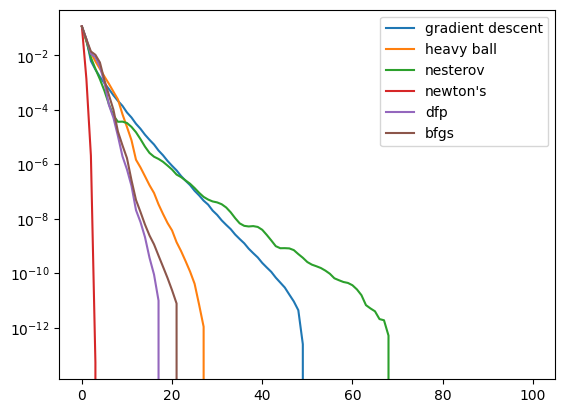

In [125]:
def f(w):
    return np.log(1.0 + np.exp(-y * X.dot(w))).mean() + np.linalg.norm(w) ** 2


def g(w):
    sig = np.exp(-y * X.dot(w))
    return 2 * w - X.T.dot(sig * y / (sig + 1.0)) / X.shape[0]


def h(w):
    X_rows, w_rows = X.shape
    t_0 = np.exp(-(y * (X).dot(w)))
    t_1 = t_0 * y
    t_2 = np.ones(X_rows) + t_0
    hess = (2 * np.eye(w_rows, w_rows)) - 1 / X_rows * (
        (((((t_1 * t_0) * y) / (t_2 * t_2))[:, np.newaxis] * X).T).dot(X)
        - (((((y * t_0) * y) / t_2)[:, np.newaxis] * X).T).dot(X)
    )
    return hess


X, y = make_classification(
    1000,
    80,
    n_informative=40,
    # n_redundant=0,
    n_clusters_per_class=2,
    flip_y=0.1,
    random_state=0,
)

x0 = np.zeros(80)
x_star = minimize(f, x0, jac=g).x

plot_error(x0, f, g, h, x_star)